<a href="https://colab.research.google.com/github/ihatethinkingname/dl_practice/blob/main/optNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# # Use comet for experiment management

# !pip install comet_ml > /dev/null 2>&1
# import comet_ml
# from google.colab import userdata
# COMET_API_KEY=userdata.get('comet_api_key')

# # Create a Comet experiment to track our training run
# def create_experiment(args):
#   # End any prior experiments
#   if 'experiment' in locals():
#     experiment.end()

#   # Initiate the comet experiment for tracking
#   experiment = comet_ml.Experiment(
#                   api_key=COMET_API_KEY,
#                   project_name="sasrec_practice")

#   # Log our hyperparameters, defined above, to the experiment
#   for param, value in vars(args).items():
#     experiment.log_parameter(param, value)
#   experiment.flush()

#   return experiment

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
from IPython import display as ipythondisplay

In [17]:
class PeriodicPlotter:
  def __init__(self, sec, xlabel="", ylabel="", scale=None):
    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
          plt.plot(data)
      elif self.scale == "semilogx":
          plt.semilogx(data)
      elif self.scale == "semilogy":
          plt.semilogy(data)
      elif self.scale == "loglog":
          plt.loglog(data)
      else:
          raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel)
      plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

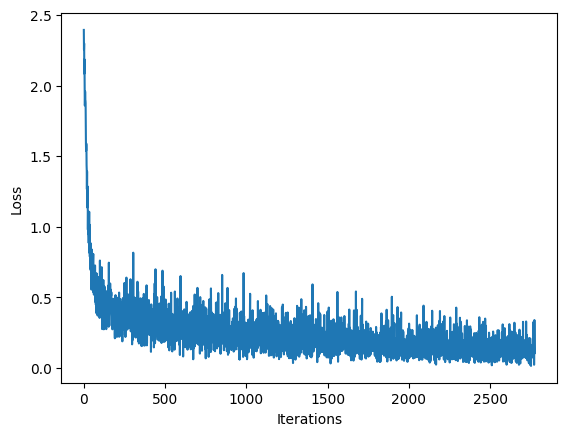

Epoch 3, Loss: 0.1463
Accuracy on test set: 96.11%


In [14]:
# 1. 数据准备
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

# 2. 定义一个简单的神经网络
class SimpleNN(nn.Module):
  def __init__(self):
    super(SimpleNN, self).__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(28*28, 128)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.flatten(x)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x

class sgdNN(nn.Module):
  def __init__(self,model):
    super.__init__()
    self.n=sum(p for p in model.parameters())
    self.n2n=nn.Linear(self.n,self.n)
    nn.init.constant_(self.n2n.weight, 1.0)

  def step(self,model):
    x=torch.tensor([param.grad for param in model.parameters()])
    with torch.no_grad():
      for param in model.parameters():
        param -= lr * self.n2n(x)
    model.zero_grad

layerParamList=[1.0,1.0]

model = SimpleNN()

# 3. 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
model_lr=1e-4
opt_lr=1e-6

# 4. 训练模型
epochs = 3
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
loss_history=[]
for epoch in range(epochs):
  model.train()
  running_loss=0.0
  for images, labels in trainloader:
    # optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    # optimizer.step()
    with torch.no_grad():
      i=0
      for param in model.parameters():
        print(i)
        param-=model_lr*param.grad*layerParamList[i]
        layerParamList[i]-=
        i++

    running_loss += loss.item()
    loss_history.append(loss.item())
    plotter.plot(loss_history)

  avg_loss = running_loss / len(trainloader)
  print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# 5. 测试模型
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")
